In [1]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time

from functools import wraps
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

import numpy as np
import matplotlib.pyplot as plt

#sys.path.insert(0,'/groups/astro/robinboe/mass_analysis')
#sys.path.insert(0,'/groups/astro/robinboe/mass_analysis/computable-information-density')
#from joblib import Parallel, delayed

from ComputableInformationDensity.cid import interlaced_time, cid2d
from ComputableInformationDensity.computable_information_density import cid

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame

In [56]:
def timeit(func):
    @wraps(func)   # keeps function name/docs intact
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)   # call the real function
        end = time.perf_counter()
        print(f"{func.__name__} runtime: {end - start:.3f} s")
        return result
    return wrapper

def get_allowed_time_intervals(system_size, nbits_max = 8):
    """
    Get allowed intervals for CID calculation based on system size and max bits.
    """
    allowed_intervals = []
    
    # system size must be divisible by 2^n

    if np.log2(system_size) % 1 != 0:
        warnings.warn("System size must be a power of 2 for exact interval calculation.")
        return
    if not type(nbits_max) == int:
        raise ValueError("nbits_max must be an integer.")

    for nbits in range(1, nbits_max + 1):
        interval_exp = 3 * nbits - 2 * np.log2(system_size)

        if interval_exp < 0:
            continue

        allowed_intervals.append({'time_interval': int(2 ** interval_exp), 'nbits': nbits})
    return allowed_intervals

def lz77py(sequence):
    """ Lempel-Ziv 77 complexity \n
    Note: The input sequence is cast as string 
    and not tuple (for performance reasons).
    """
    seq = ''.join(map(str, sequence))
    complexity, ind, inc = 1, 1, 0
    while ind + inc < len(seq):
        if seq[ind : ind + inc + 1] in seq[: ind + inc]:
            inc += 1
        else:
            complexity += 1
            ind += inc + 1
            inc = 0
    return complexity + 1 if inc != 0 else complexity

#@timeit
def block_flatten(array, m, k):
    """
    Efficiently flatten a 2D array into m x k blocks traversed horizontally.
    
    Parameters:
        array (np.ndarray): Input 2D array of shape (M, N)
        m (int): Number of rows per block
        k (int): Number of columns per block
        
    Returns:
        np.ndarray: Flattened 1D array of blocks
    """
    M, N = array.shape

    # Check divisibility
    if M % m != 0:
        raise ValueError(f"Number of rows {M} is not divisible by block row size {m}.")
    if N % k != 0:
        raise ValueError(f"Number of columns {N} is not divisible by block column size {k}.")
    
    # Reshape array into blocks
    reshaped = array.reshape(M//m, m, N//k, k)
    # Transpose to bring blocks into row-major order: (block_row, block_col, m, k)
    reshaped = reshaped.transpose(0, 2, 1, 3)
    # Flatten all blocks
    return reshaped.reshape(-1)

def _shuffle_generator(seq, nshuff, rng):
    """Yield reshuffled copies of a working array."""
    arr = seq.copy()  # one upfront copy
    for _ in range(nshuff):
        rng.shuffle(arr)        # shuffle in place
        yield arr.copy()        # copy here so workers don't share buffer

#@timeit
def cid_shuffle_dev(sequence, nshuff, ddof = 1):
    """Computable Information Density via random shuffling.
    
    Args:
        sequence : np.ndarray
            One-dimensional data array.
        nshuff   : int
            Number of shuffles.
    Returns:
        float : Mean CID value over shuffled sequences.
    """
    rng = np.random.default_rng()  # independent RNG

    # Generate reshuffled arrays lazily
    shuffled_iter = _shuffle_generator(sequence, nshuff, rng)

    with Pool(min(cpu_count(), nshuff)) as pool:
        cid_values = pool.map(cid, shuffled_iter)  # cid must be top-level
    return np.mean(cid_values), np.std(cid_values, ddof=ddof if nshuff > 1 else 0)


def hilbert_curve(n, p):
    """ Principal Hilbert Curve. \n
    
    Vectorized implementation of the principal Hilbert curve by J. Skilling.
    
    Reference:
    J. Skilling, "Programming the Hilbert curve". AIP Conf. Proc., 2004, 707, 
    381-387.
    
    Algorithm:
    A single global Gray code is being applied to the np-bit binary rep. of the 
    Hilbert distance/index H. This overtransforms the distance H and the excess 
    work is undone by a single traverse through the np-bit Gray code rep. of H.
    
    Args:
        n: dimensionality of the curve (int).
        p: number of bits in each dimension (int).
    
    Returns:
        Two-dimensional numpy array with shape (n, 2**(n * p)) Entry (i,j) contains the the i'th component
        of the coordinate to the j'th point along the principal Hilbert curve.
    """
    
    H = np.arange(1 << n*p) # distance along the Hilbert curve
    H ^= H >> 1             # Gray code / reflected binary code
    
    # unpackbits:
    H = H & 1 << np.arange(n*p)[:, None] != 0
    
    # collect each np-bit integer into n preliminary p-bit integers:
    H = H.reshape(p, n, -1)
    
    # packbits:
    H = np.sum(H.T * 1 << np.arange(p), -1)
    
    H = H.T # this makes life less awkward
    
    # undo excess work:
    for q in 2 << np.arange(p - 1):
        for m in range(n):
            # if bit q of of coordinate m is OFF
            mask = H[m] & q == 0
            # then exchange low bits of coordinate n and m:
            H[:, mask] ^= (H[-1, mask] ^ H[m, mask]) & q - 1
            # else invert low bits of coordinate n:
            H[-1, np.logical_not(mask)] ^= q - 1
    
    return H

def itter_hscan(data, dim, nbits):
        """ yields all 8 distinct Hilbert scanned views of the data. 
        Since a view is returned, this operation is O(1). """
        hamiltonian_cycle = [0, 1, 0, 2, 1, 0, 1, 2]
        principal_curve = hilbert_curve(dim, nbits)
        size = 1 << nbits  # 2**nbits
        for k in hamiltonian_cycle:
            hcurve = principal_curve  # view of principal_curve i.e. O(1)
            
            if k == 0: hcurve[0] = (size - 1) - hcurve[0]
            if k == 1: hcurve[1] = (size - 1) - hcurve[1]
            if k == 2: hcurve[[0,1]] = hcurve[[1,0]]
            yield data[tuple( hcurve )].T.ravel()  # view of data, i.e. O(1)

In [156]:
#@timeit
def lz77py(sequence, window_size = None):
    """ Lempel-Ziv 77 complexity \n
    Note: The input sequence is cast as string 
    and not tuple (for performance reasons).
    """
    seq = ''.join(map(str, sequence))
    #comp_list = [seq[0]]
    complexity, ind, inc = 1, 1, 0
    while ind + inc < len(seq):
        fidx = max(ind - window_size, 0) if window_size is not None else 0
        if seq[ind : ind + inc + 1] in seq[fidx: ind + inc]:
            inc += 1
        else:
            #comp_list.append(seq[ind : ind + inc + 1])
            complexity += 1
            ind += inc + 1
            inc = 0

    #comp_list = comp_list if inc == 0 else comp_list + [seq[ind : ind + inc + 1]]
    #print(comp_list)
    return complexity + 1 if inc != 0 else complexity


def lz77_py(seq):
    """ Lempel-Ziv 77 complexity \n
    Note: The input sequence is cast as string 
    and not tuple (for performance reasons).
    """
    seq = ''.join(map(str, seq))
    complexity, ind, inc = 1, 1, 0
    comp_list = [seq[0]]
    while ind + inc < len(seq):
        if seq[ind : ind + inc + 1] in seq[: ind + inc]:
            print(ind, ind+inc)
            print(seq[ind : ind + inc + 1], "IN", seq[: ind + inc])
            inc += 1
        else:
            print("NEW ", seq[ind : ind + inc + 1])
            comp_list.append(seq[ind : ind + inc + 1])
            complexity += 1
            ind += inc + 1
            inc = 0
    comp_list = comp_list if inc == 0 else comp_list + [seq[ind : ind + inc + 1]]
    print(comp_list)
    return complexity + 1 if inc != 0 else complexity

#@timeit
def lz77_complexity(seq):
    """
    Optimized Lempel-Ziv 77 complexity (number of phrases).
    Works for sequences of ints, chars, or strings.
    """
    seq = ''.join(map(str, seq))
    n = len(seq)
    if n == 0:
        return 0

    complexity = 0
    i = 0  # start index
    j = 1  # end index

    # Maintain a hash set of substrings we've seen
    seen = set()
    while j <= n:
        substring = seq[i:j]
        if substring in seen:
            j += 1
        else:
            # New phrase found
            seen.add(substring)
            complexity += 1
            i = j
            j = i + 1
   # print("SEEN: ", seen)
    return complexity


#@timeit
def lz77_complexity_comp(seq, window_size = 0):
    """
    Optimized Lempel-Ziv 77 complexity (number of phrases).
    Works for sequences of ints, chars, or strings.
    """
    seq = ''.join(map(str, seq))
    n = len(seq)
    if n == 0:
        return 0

    complexity = 0
    i = 0  # start index
    j = 1  # end index

    # Maintain a hash set of substrings we've seen 
    seen = set()
    while j <= n:
        substring = seq[i:j]
        fidx = max(i - window_size, 0) if window_size is not None else 0
        if substring in seen or substring in seq[fidx:j-1]:
            j += 1
        else:
            # New phrase found
            seen.add(substring)
            complexity += 1
            i = j
            j = i + 1
   # print("SEEN: ", seen)
    return complexity


class SuffixAutomaton:
    def __init__(self):
        self.states = [{}]        # transitions
        self.link = [-1]          # suffix links
        self.length = [0]         # state lengths
        self.last = 0             # current state

    def extend(self, c):
        cur = len(self.states)
        self.states.append({})
        self.length.append(self.length[self.last] + 1)
        self.link.append(0)
        p = self.last

        # Step 1: follow suffix links until we find a state without c
        while p >= 0 and c not in self.states[p]:
            self.states[p][c] = cur
            p = self.link[p]

        if p == -1:
            self.link[cur] = 0
        else:
            q = self.states[p][c]
            if self.length[p] + 1 == self.length[q]:
                self.link[cur] = q
            else:
                clone = len(self.states)
                self.states.append(self.states[q].copy())
                self.length.append(self.length[p] + 1)
                self.link.append(self.link[q])
                while p >= 0 and self.states[p].get(c) == q:
                    self.states[p][c] = clone
                    p = self.link[p]
                self.link[q] = self.link[cur] = clone

        self.last = cur


def lz77_complexity_suffix_automaton(seq):
    """
    Lempel–Ziv 77 complexity using suffix automaton.
    O(N) time and space.
    """
    seq = ''.join(map(str, seq))
    n = len(seq)
    if n == 0:
        return 0

    sam = SuffixAutomaton()
    complexity = 1
    current_len = 0

    for c in seq:
        sam.extend(c)
        # Try to extend current phrase
        # If extension failed, new phrase starts
        if current_len == sam.length[sam.last]:
            complexity += 1
            current_len = 0
        else:
            current_len += 1

    return complexity


class SAMNode:
    def __init__(self):
        self.next = {}       # transitions
        self.link = -1       # suffix link
        self.len = 0         # max length of substring ending here

class SuffixAutomaton:
    def __init__(self):
        self.nodes = [SAMNode()]
        self.last = 0

    def extend(self, c):
        p = self.last
        cur = len(self.nodes)
        node = SAMNode()
        node.len = self.nodes[p].len + 1
        self.nodes.append(node)

        while p >= 0 and c not in self.nodes[p].next:
            self.nodes[p].next[c] = cur
            p = self.nodes[p].link

        if p == -1:
            node.link = 0
        else:
            q = self.nodes[p].next[c]
            if self.nodes[p].len + 1 == self.nodes[q].len:
                node.link = q
            else:
                clone = len(self.nodes)
                cloned_node = SAMNode()
                cloned_node.next = self.nodes[q].next.copy()
                cloned_node.link = self.nodes[q].link
                cloned_node.len = self.nodes[p].len + 1
                self.nodes.append(cloned_node)

                while p >= 0 and self.nodes[p].next.get(c) == q:
                    self.nodes[p].next[c] = clone
                    p = self.nodes[p].link

                self.nodes[q].link = clone
                node.link = clone

        self.last = cur


def lz77_complexity_linear(seq):
    """
    Linear-time Lempel-Ziv 77 complexity using suffix automaton.
    Matches the original parsing exactly.
    """
    seq = ''.join(map(str, seq))
    n = len(seq)
    if n == 0:
        return 0

    sam = SuffixAutomaton()
    complexity = 0
    i = 0  # start of current phrase

    while i < n:
        length = 0
        node = 0
        j = i
        # extend as far as possible in the automaton
        while j < n and seq[j] in sam.nodes[node].next:
            node = sam.nodes[node].next[seq[j]]
            length += 1
            j += 1

        # new phrase found
        complexity += 1

        # insert all new characters of this phrase into the SAM
        for k in range(i, min(i + length + 1, n)):
            sam.extend(seq[k])


        i += length + 1  # move to next phrase

    return complexity


In [180]:
256*256*256, 1400*1400

(16777216, 1960000)

In [194]:
window_size=3000
lens = np.arange(200,1000,200).astype(int)
Nruns = len(lens)
lz_comp_times_unc = np.zeros(Nruns)
lz_comp_times = np.zeros(Nruns)
lz_comp_times_opt = np.zeros(Nruns)
lz_comp_times_sa = np.zeros(Nruns)
lz_vals_unc = np.zeros(Nruns)
lz_vals = np.zeros(Nruns)
lz_vals_opt = np.zeros(Nruns)   
lz_vals_sa = np.zeros(Nruns)

for i, l in enumerate(lens):
    print(f"Testing length: {l} x {l}")
    test_seq = np.random.binomial(1,0.006,size=l*l)
    #print(test_seq)
    if 0:

        t1 = time.perf_counter()
        lz = lz77py(test_seq.copy(), window_size=window_size)
    t2 = time.perf_counter()
    lz_comp_times[i] = t2-t1
    lz_vals[i] = lz
    lz_opt = lz77_complexity_comp(test_seq, window_size=window_size)
    t3 = time.perf_counter()
    lz_comp_times_opt[i] = t3-t2
    lz_vals_opt[i] = lz_opt
    lz_sa = lz77_complexity_linear(test_seq)
    t4 = time.perf_counter()
    lz_comp_times_sa[i] = t4-t3
    lz_vals_sa[i] = lz_sa
    if 0:
        lz = lz77py(test_seq.copy(), window_size=2*window_size)
        t5 = time.perf_counter()
        lz_comp_times_unc[i] = t5-t4
        lz_vals_unc[i] = lz
    

   # print(f"Length: {l}, LZ77: {lz}, LZ77_opt: {lz_opt}, Match: {lz == lz_opt}")

Testing length: 200 x 200
Testing length: 400 x 400
Testing length: 600 x 600
Testing length: 800 x 800


In [197]:
lz77py(defect_grid[0,:,:].ravel())

24

In [210]:
lz77_complexity_linear(defect_grid[:,:,:].ravel())

91

In [209]:
lz77_complexity_comp(defect_grid[2,:,:].ravel(),window_size=1024*2)

40

In [196]:
print(lz77_complexity_comp(defect_grid[2,:,:].ravel(),window_size=2500), lz77_complexity_linear(defect_grid[0,:,:].ravel()))#, lz77py(defect_grid[0,:,:].ravel()))

37 34


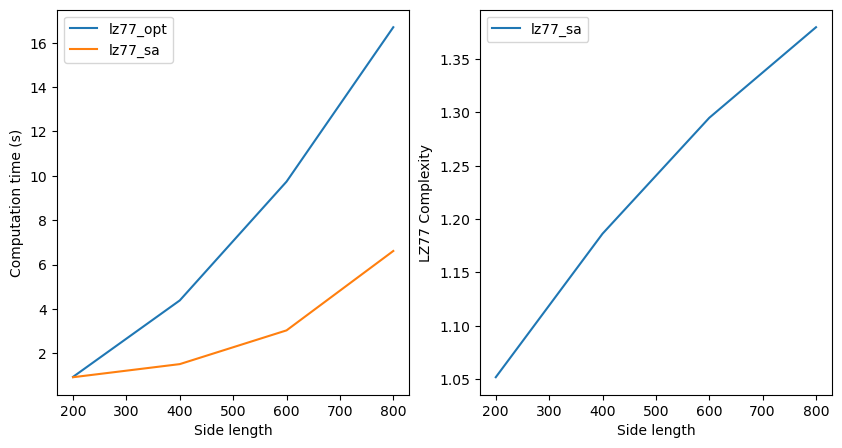

In [195]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
#ax[0].plot(np.array(lens), lz_comp_times, label='lz77py')
ax[0].plot(np.array(lens), lz_comp_times_opt, label='lz77_opt')
ax[0].plot(np.array(lens), lz_comp_times_sa, label='lz77_sa')
#ax[0].plot(np.array(lens), lz_comp_times_unc, label='lz77_unc')
ax[0].set_xlabel("Side length")
ax[0].set_ylabel("Computation time (s)")
ax[0].legend()
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')
#ax[1].plot(np.array(lens), lz_vals, 'x', label='lz77py')
#ax[1].plot(np.array(lens), lz_vals_opt, label='lz77_opt')
#ax[1].plot(np.array(lens), lz_vals_sa, label='lz77_sa')
ax[1].plot(np.array(lens),lz_vals_opt/ lz_vals_sa, label='lz77_sa')

#ax[1].plot(np.array(lens), lz_vals_unc, label='lz77_unc')
ax[1].set_xlabel("Side length")
ax[1].set_ylabel("LZ77 Complexity")
ax[1].legend()

In [50]:

lens = [2**i for i in range(1,3)]
lens = [8]
lz_vals = []
lz_opt_vals = []
for l in lens:
    test_seq = np.random.randint(0,2,size=l)
    print(test_seq)
    lz = lz77_py(test_seq.copy())
   # lz_opt = lz77_complexity(test_seq)
    lz_vals.append(lz)
    #lz_opt_vals.append(lz_opt)
   # print(f"Length: {l}, LZ77: {lz}, LZ77_opt: {lz_opt}, Match: {lz == lz_opt}")

[0 0 0 1 1 1 1 1]
1 1
0 IN 0
1 2
00 IN 00
NEW  001
4 4
1 IN 0001
4 5
11 IN 00011
4 6
111 IN 000111
4 7
1111 IN 0001111
['0', '001', '1111']


In [4]:
256**3

16777216

In [11]:
N = 2
M = 2
kN = 1

system_size = N + M
nframes = 4

allowed_intervals_list = get_allowed_time_intervals(system_size = system_size, nbits_max=8)

# check that nframes is in allowed intervals
if nframes not in [ai['time_interval'] for ai in allowed_intervals_list]:
    raise ValueError(f"nframes {nframes} is not in allowed intervals {allowed_intervals_list}")
else:
    # get nbits for nframes
    nbits = [ai['nbits'] for ai in allowed_intervals_list if ai['time_interval'] == nframes][0]

np0, np1 = -1,2
mblock, nblock = 2,2

npoints = 1000
nshuffle=32

# construct array with order along both axes
X=np.block([[
    np.zeros((N,kN*N)),
    np.ones((N,kN*N))],
    [0*np.ones((M,kN*N)),
     0*np.ones((M,kN*N)),]
    ]).astype(int)
# contruct array with order along one axis
Xpermute = X.astype(int) #np.roll(X, shift=-2, axis=0)
Xpermute[[0,np0],:] = X[[np0,0],:]
Xpermute[[1, np1],:] = X[[np1,1],:]

In [24]:
time_interval=4
X = np.linspace(1, size*size*time_interval, size*size*time_interval).reshape(size, size, time_interval)
X

array([[[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.]],

       [[17., 18., 19., 20.],
        [21., 22., 23., 24.],
        [25., 26., 27., 28.],
        [29., 30., 31., 32.]],

       [[33., 34., 35., 36.],
        [37., 38., 39., 40.],
        [41., 42., 43., 44.],
        [45., 46., 47., 48.]],

       [[49., 50., 51., 52.],
        [53., 54., 55., 56.],
        [57., 58., 59., 60.],
        [61., 62., 63., 64.]]])

In [61]:
@timeit
def itter_hscan(data, dim, nbits):
        """ yields all 8 distinct Hilbert scanned views of the data. 
        Since a view is returned, this operation is O(1). """
        hamiltonian_cycle = [0, 1, 0, 2, 1, 0, 1, 2]
        principal_curve = hilbert_curve(dim, nbits)
        size = 1 << nbits  # 2**nbits
    
        for k in hamiltonian_cycle:
            hcurve = principal_curve  # view of principal_curve i.e. O(1)
            if k == 0: hcurve[0] = (size - 1) - hcurve[0]
            if k == 1: hcurve[1] = (size - 1) - hcurve[1]
            if k == 2: hcurve[[0,1]] = hcurve[[1,0]]
            yield data[tuple( hcurve )].T.ravel()  # view of data, i.e. O(1)

In [ ]:
dim=3
bits_max = 8
lx = 8
allowed_idx=2
dt =get_allowed_time_intervals(lx,nbits_max=12)[allowed_idx]['time_interval']
nbits = get_allowed_time_intervals(lx,nbits_max=12)[allowed_idx]['nbits']


X=np.ones((lx,lx,dt), dtype=int)
X=np.linspace(0, lx*lx*dt, lx*lx*dt, dtype=int).reshape((lx,lx,dt))
X=np.squeeze(X) if dt==1 else X
dim=X.ndim

print(1<<nbits, dt)

data = np.transpose(X).reshape((-1, ) + (1<<nbits, ) * dim).T
print(X.shape, data.shape)
X[0], tuple(data[0,:2,:])


In [ ]:
dim=3
#nbits=10

size = 512


time_interval = 2

print(size)

if dim==2:
    X = np.linspace(1, size*size, size*size).reshape(size, size)
elif dim==3:
    X = np.linspace(1, size*size*time_interval, size*size*time_interval).reshape(size, size, time_interval)

H = hilbert_curve(n=dim, p = nbits)
H.shape, dim, 2**(nbits*dim)
#itter_hscan(X, dim=dim, nbits=nbits)

t1 = time.perf_counter()
# calculate itter_hscan for X
scans2d = list(itter_hscan(X, dim=dim, nbits=nbits))
print(f"2d itter_hscan time: {time.perf_counter() - t1:.3f} s")

# check if scans2d and scans3d are the same
if 0:
    for i in range(len(scans2d)):
        print(f"scan {i}: 2d shape {scans2d[i].shape}, 3d shape {scans3d[i].shape}")
        print(f"scan {i} equal: {np.array_equal(scans2d[i], scans3d[i])}")

In [ ]:
dim=3
nbits=2
size = 2**nbits
time_interval = 4

if dim==2:
    X = np.linspace(1, size*size, size*size).reshape(size, size)
elif dim==3:
    X = np.linspace(1, size*size*time_interval, size*size*time_interval).reshape(size, size, time_interval)

H = hilbert_curve(n=dim, p = nbits)
H.shape, dim, 2**(nbits*dim)
itter_hscan(X, dim=dim, nbits=nbits)

# calculate itter_hscan for X
scans = list(itter_hscan(X, dim=dim, nbits=nbits))
scans

[array([13., 14., 10.,  9.,  5.,  1.,  2.,  6.,  7.,  3.,  4.,  8., 12.,
        11., 15., 16.]),
 array([16., 15., 11., 12.,  8.,  4.,  3.,  7.,  6.,  2.,  1.,  5.,  9.,
        10., 14., 13.]),
 array([ 4.,  3.,  7.,  8., 12., 16., 15., 11., 10., 14., 13.,  9.,  5.,
         6.,  2.,  1.]),
 array([13.,  9., 10., 14., 15., 16., 12., 11.,  7.,  8.,  4.,  3.,  2.,
         6.,  5.,  1.]),
 array([16., 12., 11., 15., 14., 13.,  9., 10.,  6.,  5.,  1.,  2.,  3.,
         7.,  8.,  4.]),
 array([ 4.,  8.,  7.,  3.,  2.,  1.,  5.,  6., 10.,  9., 13., 14., 15.,
        11., 12., 16.]),
 array([ 1.,  5.,  6.,  2.,  3.,  4.,  8.,  7., 11., 12., 16., 15., 14.,
        10.,  9., 13.]),
 array([ 1.,  2.,  6.,  5.,  9., 13., 14., 10., 11., 15., 16., 12.,  8.,
         7.,  3.,  4.])]

In [135]:
base_path = 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na512'
d_cluster_l = dict(path = base_path + 'l_cl', \
              suffix = "l_cl", priority = 1, LX = 512, Nframes = 400)
d_cluster_vl = dict(path = base_path + 'vl_cl', \
              suffix = "vl_cl", priority = 1, LX = 512, Nframes = 1500)
d_list = [d_cluster_l, d_cluster_vl]

Nexp_l, act_l, act_dir_l = gen_clustering_metadata(d_cluster_l['path'])
Nframes_l = 400
Nexp_vl, act_vl, act_dir_vl = gen_clustering_metadata(d_cluster_vl['path'])
Nframes_vl = 1500

## Choose which dataset to visualize
act = 0.022
act_idx = act_vl.index(act)
num_exp = 0
rmax = 33
folder_path = os.path.join(act_dir_vl[act_idx], f'zeta_{act}_counter_{num_exp}')
defect_path = os.path.join(folder_path, 'defect_positions.pkl')
labels_path = os.path.join(folder_path, 'labels_rm33.pkl')

with open(defect_path, 'rb') as f:
    defect_list = pkl.load(f)
with open(labels_path, 'rb') as f:
    labels = pkl.load(f)

In [ ]:
nframes, nx, ny = 8, d_cluster_l['LX'], d_cluster_l['LX']
observation_window_bounds = [(0, int(nx / 2)), (0, int(ny / 2))]
lx_observation_window = observation_window_bounds[0][1] - observation_window_bounds[0][0]


256

In [131]:
get_allowed_time_intervals(256,12)

[{'time_interval': 4, 'nbits': 6},
 {'time_interval': 32, 'nbits': 7},
 {'time_interval': 256, 'nbits': 8},
 {'time_interval': 2048, 'nbits': 9},
 {'time_interval': 16384, 'nbits': 10},
 {'time_interval': 131072, 'nbits': 11},
 {'time_interval': 1048576, 'nbits': 12}]

In [136]:
nframes, nx, ny = 4, d_cluster_l['LX'], d_cluster_l['LX']
observation_window_bounds = [(0, int(nx / 2)), (0, int(ny / 2))]
lx_window = observation_window_bounds[0][1] - observation_window_bounds[0][0]
ly_window = observation_window_bounds[1][1] - observation_window_bounds[1][0]

if not lx_window == ly_window:
    raise ValueError("Observation window must be square.")

allowed_intervals_list = get_allowed_time_intervals(system_size = lx_window, nbits_max=8)

# check that nframes is in allowed intervals
if nframes not in [ai['time_interval'] for ai in allowed_intervals_list]:
    raise ValueError(f"nframes {nframes} is not in allowed intervals {allowed_intervals_list}")
else:
    # get nbits for nframes
    nbits = [ai['nbits'] for ai in allowed_intervals_list if ai['time_interval'] == nframes][0]

print(f"Using nbits = {nbits} (size {1 << nbits}) for nframes = {nframes} and window size {lx_window}x{ly_window}")

defect_grid = np.zeros((nframes, lx_window, ly_window), dtype=int)
defect_density = []

for i, defect in enumerate(defect_list[:nframes]):
    def_arr = get_defect_arr_from_frame(defect).astype(int)

    def_arr_xmask = (observation_window_bounds[0][0] < def_arr[:,0]) & (def_arr[:,0] < observation_window_bounds[0][1])
    def_arr_ymask = (observation_window_bounds[0][0] < def_arr[:,1]) & (def_arr[:,1] < observation_window_bounds[0][1])
    def_arr = def_arr[def_arr_xmask & def_arr_ymask]

    defect_grid[i, def_arr[:,0], def_arr[:,1]] = 1
    defect_density.append(defect_grid[i,:,:].mean())



Using nbits = 6 (size 64) for nframes = 4 and window size 256x256


In [ ]:
# instantiate CID object:
nshuffle=2
mblock, kblock = 2,2
t1 = time.perf_counter()
CID = interlaced_time(nbits=nbits, nshuff=nshuffle)

cid_, cid_shuff = CID(defect_grid.copy())
print(f"Interlaced: CID, CID_shuff, ratio: {cid_}, {cid_shuff}", cid_/cid_shuff)
t2 = time.perf_counter()


if 0:
    print(f"Time taken: {(t2 - t1):.1f} seconds")
    CID2d = cid2d(nbits=nbits, nshuff=nshuffle)
    cid2d_, cid2d_shuff = CID2d(defect_grid.copy())
    print(f"cid2d: CID, CID_shuff, ratio: {cid2d_},{cid2d_shuff}", cid2d_/cid2d_shuff)
    t2 = time.perf_counter()
    print(f"Time taken: {(t2 - t1):.1f} seconds")

    cid_list = []
    cid_list_block = []
    cid_shuffle_list_block = []
    cid_shuffle_list = []
    for i in range(nframes):
        Xblock = block_flatten(Xt[i,:,:], m=mblock, k=nblock)
        cid_list_block.append(cid(Xblock.astype(int).flatten()))
        cid_shuffle_list_block.append(cid_shuffle_dev(Xblock.flatten(), nshuff=nshuffle)[0])
        cid_list.append(cid(Xt[i,:,:].astype(int).flatten()))
        cid_shuffle_list.append(cid_shuffle_dev(Xt[i,:,:].flatten(), nshuff=nshuffle)[0])
    print("Sequential: CID, CID_shuff, ratio: ", np.mean(cid_list), np.mean(cid_shuffle_list), np.mean(cid_list)/ np.mean(cid_shuffle_list),)
    print("Block flattened: CID, CID_shuff, ratio: ", np.mean(cid_list_block), np.mean(cid_shuffle_list_block), np.mean(cid_list_block)/ np.mean(cid_shuffle_list_block),)
    print("time taken: ", (time.perf_counter() - t2)/2)

In [ ]:
   
N = 16
M = 16
kN = 1

system_size = N + M
nframes = 32

allowed_intervals_list = get_allowed_time_intervals(system_size = system_size, nbits_max=8)

# check that nframes is in allowed intervals
if nframes not in [ai['time_interval'] for ai in allowed_intervals_list]:
    raise ValueError(f"nframes {nframes} is not in allowed intervals {allowed_intervals_list}")
else:
    # get nbits for nframes
    nbits = [ai['nbits'] for ai in allowed_intervals_list if ai['time_interval'] == nframes][0]

np0, np1 = -1,9
mblock, nblock = 2,2

npoints = 1000
nshuffle=32

# construct array with order along both axes
X=np.block([[
    np.zeros((N,kN*N)),
    np.ones((N,kN*N))],
    [0*np.ones((M,kN*N)),
     0*np.ones((M,kN*N)),]
    ]).astype(int)
# contruct array with order along one axis
Xpermute = X.astype(int) #np.roll(X, shift=-2, axis=0)
Xpermute[[0,np0],:] = X[[np0,0],:]
Xpermute[[1, np1],:] = X[[np1,1],:]

Xt = np.repeat(X[None,:,:],nframes,axis=0)   #np.dstack([X]*nframes,axis=0)
Xt = np.repeat(Xpermute[None,:,:],nframes,axis=0)   #np.dstack([X]*nframes,axis=0)
print(Xt.shape, X.shape)
print(X)

In [138]:
# instantiate CID object:
nshuffle=4
mblock, kblock = 2,2
t1 = time.perf_counter()
CID = interlaced_time(nbits=nbits, nshuff=nshuffle)

cid_, cid_shuff = CID(Xt.copy())
print(f"Interlaced: CID, CID_shuff, ratio: {cid_}, {cid_shuff}", cid_/cid_shuff)
t2 = time.perf_counter()
print(f"Time taken: {(t2 - t1):.1f} seconds")
CID2d = cid2d(nbits=nbits, nshuff=nshuffle)
cid2d_, cid2d_shuff = CID2d(Xt.copy())
print(f"cid2d: CID, CID_shuff, ratio: {cid2d_},{cid2d_shuff}", cid2d_/cid2d_shuff)
t2 = time.perf_counter()
print(f"Time taken: {(t2 - t1):.1f} seconds")

cid_list = []
cid_list_block = []
cid_shuffle_list_block = []
cid_shuffle_list = []
for i in range(nframes):
    Xblock = block_flatten(Xt[i,:,:], m=mblock, k=nblock)
    cid_list_block.append(cid(Xblock.astype(int).flatten()))
    cid_shuffle_list_block.append(cid_shuffle_dev(Xblock.flatten(), nshuff=nshuffle)[0])
    cid_list.append(cid(Xt[i,:,:].astype(int).flatten()))
    cid_shuffle_list.append(cid_shuffle_dev(Xt[i,:,:].flatten(), nshuff=nshuffle)[0])
print("Sequential: CID, CID_shuff, ratio: ", np.mean(cid_list), np.mean(cid_shuffle_list), np.mean(cid_list)/ np.mean(cid_shuffle_list),)
print("Block flattened: CID, CID_shuff, ratio: ", np.mean(cid_list_block), np.mean(cid_shuffle_list_block), np.mean(cid_list_block)/ np.mean(cid_shuffle_list_block),)
print("time taken: ", (time.perf_counter() - t2)/2)

Interlaced: CID, CID_shuff, ratio: 0.0751149831507952, 1.046482492358989 0.07177853781525807
Time taken: 5.9 seconds
cid2d: CID, CID_shuff, ratio: 0.013627858941792376,1.0440436622134668 0.013052958832104862
Time taken: 14.8 seconds
Sequential: CID, CID_shuff, ratio:  0.10204123534733699 1.1535442938006686 0.08845887920882006
Block flattened: CID, CID_shuff, ratio:  0.14792058104201092 1.1542813433934853 0.12814950348858403
time taken:  13.283701700000165


In [ ]:
dim=3
bits_max = 8
lx = 16
allowed_int_idx = 1

allowed_intervals = get_allowed_time_intervals(lx, bits_max)

nframes=allowed_intervals[allowed_int_idx]['time_interval']
nbits = allowed_intervals[allowed_int_idx]['nbits']
size = 1 << allowed_intervals[allowed_int_idx]['nbits']
print(f"nframes: {nframes}, nbits: {nbits}, size: {size}"   )
X=np.ones((nframes, lx, lx))



nframes: 16, nbits: 4, size: 16
CID interlaced: 0.021484375, CID shuffled interlaced: 0.021484375
Time taken: 1.5 seconds
CID 2d: 0.8321814137333032, CID shuffled 2d: 0.8237646426378623
Time taken: 2.8 seconds


In [114]:
data = np.transpose(Xt).reshape((-1, ) + (1<<nbits, ) * 3).T
X.shape, data.shape

((16, 16), (8, 8, 8, 1))

In [ ]:
nframes, nx, ny = 512, 1024, 1024

# instantiate CID object:
CID = interlaced_time(8, 16)

defects = zeros((nframes, nx, ny), dtype=int)
defect_density = []

ar = archive.loadarchive(f'/lustre/astro/kpr279/ns2048/output_test_zeta_{zeta}/output_test_zeta_{zeta}_counter_{rep}')

print(zeta,rep)

for i in range(nframes):
    frame = ar[i]
    for defect in get_defects(frame.QQxx, frame.QQyx, frame.LX, frame.LY):
        ix, iy = defect['pos']
        ix, iy = int(ix) - nx//2, int(iy) - ny//2
        if (0 <= ix < nx) and (0 <= iy < ny): defects[i, ix, iy] = 1

    defect_density.append(defects[i,:,:].mean())

# compute cid and cid shuffle:
cid_, cid_shuff = CID(defects)

res_cid = {
    'zeta' : ar.zeta,
    'cid' : cid_,
    'cid_shuffle' : cid_shuff,
    'lambda' : 1. - cid_/cid_shuff
}

res_defect_density = {
    'zeta' : ar.zeta,
    'density' : defect_density
}

with open(f"/lustre/astro/robinboe/HD_CID/cid-results-2048/cid-results-L-2048-zeta-{zeta}-rep-{rep+1}.pkl", "wb") as file:
    pickle.dump(res_cid, file)

with open(f"/lustre/astro/robinboe/HD_CID/defect-density-results-2048/defect-density-results-L-2048-zeta-{zeta}-rep-{rep+1}.pkl", "wb") as file:
    pickle.dump(res_defect_density, file)

In [ ]:

def main(rep, zeta):
    main_cid(rep, zeta)

if __name__ == "__main__":
    zeta = float(sys.argv[1])
    rep = int(sys.argv[2])
    main(rep, zeta)
